In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from LTH_helper import LTH
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import initializers
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow_model_optimization.sparsity.keras import strip_pruning

In [3]:
my_dataset = mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = my_dataset.load_data()
X = train_images.reshape(-1, 784)/255
y = train_labels.reshape(-1, 1)
X_test = test_images.reshape(-1, 784)/255
y_test = test_labels.reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
def get_model(compile_model_flag=True, lr=0.001):
    reduce = 2
    input_dim=784
    output_size = 10
    initializer = initializers.glorot_normal()
    # Creo el modelo
    model = Sequential()
    model.add(Dense(output_size, activation='softmax', 
                    name='Salida', input_dim=input_dim,
                    kernel_initializer=initializer))
    if compile_model_flag:
        compile_model(model, lr=lr)
    return model
model = get_model()
# model.save_weights('random-init.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Salida (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [14]:
def get_callbacks(filename):
    return [
#         ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=np.sqrt(0.1), patience=10, verbose=1, min_lr=1e-4),
        ModelCheckpoint(filepath=filename,  verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
    ]

model = get_model()
epochs = 10
batch_size = 256
# Save initial weights
model.save_weights('mlp.mnist.initial_weights.hdf5')
history = model.fit(X_train, 
           y_train,
           epochs=epochs, batch_size=batch_size, 
           validation_data = (X_val, y_val),
           verbose=2, 
           callbacks=get_callbacks('mlp.mnist.first_train.hdf5')
          )

Epoch 1/10

Epoch 00001: val_accuracy improved from -inf to 0.86844, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.9233 - accuracy: 0.7765 - val_loss: 0.5299 - val_accuracy: 0.8684
Epoch 2/10

Epoch 00002: val_accuracy improved from 0.86844 to 0.89078, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.4552 - accuracy: 0.8831 - val_loss: 0.4072 - val_accuracy: 0.8908
Epoch 3/10

Epoch 00003: val_accuracy improved from 0.89078 to 0.90311, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.3798 - accuracy: 0.8980 - val_loss: 0.3620 - val_accuracy: 0.9031
Epoch 4/10

Epoch 00004: val_accuracy improved from 0.90311 to 0.91067, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.3451 - accuracy: 0.9065 - val_loss: 0.3349 - val_accuracy: 0.9107
Epoch 5/10

Epoch 00005: val_accuracy improved from 0.91067 to 0.91189, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.3246 - accuracy: 0.9116 - val_loss: 0.3209 - val_

In [15]:
# if my_dataset == mnist:
#     model.load_weights('MNIST-LR-best_untrained_acc_36.3_46.6.hdf5')
# else:
#     model.load_weights('F-MNIST-LR-best_untrained_acc_10.3_50.9.hdf5')

In [16]:
for i, layer in enumerate(model.layers):
    sparcity = (layer.get_weights()[0]==0).sum()/np.product((layer.get_weights()[0]==0).shape)    
    print(f'{layer.name}: {sparcity}')

Salida: 0.0


In [17]:
X_test.shape

(10000, 784)

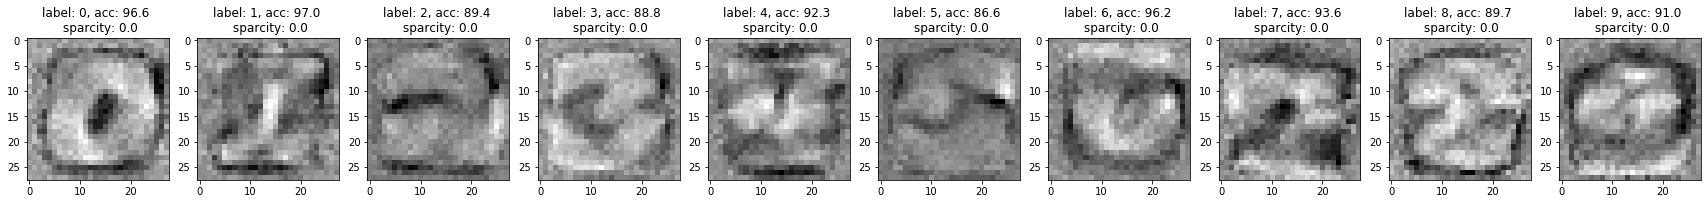

In [45]:
def plot_weights(model):
    f, axs = plt.subplots(1, 10, figsize=(30, 10))
    for number in range(10):
        w = model.get_weights()[0][:, number].reshape(28, 28)
        indexes = (y==number).reshape(-1)
        _, acc = model.evaluate(X[indexes], y[indexes], verbose=0)
        axs[number].imshow(w, cmap='gray')
        axs[number].set_title(f'label: {number}, acc: {int(acc*1000+0.5)/10} \n sparcity: {int((w==0).sum()/np.product(w.shape)*1000)/10}')
plot_weights(model)

In [30]:
lth = LTH(get_model)
pms = np.linspace(0.001, 0.999, 50)
accs_nt = []
best_acc = 0

for pm in pms:
    # Devuelve el modelo pruneado en funcion del entrenamiento
    model_pruned_layers = lth.get_prunned_model('mlp.mnist.first_train.hdf5', pm)
    # Coloca los pesos iniciales en los lugares sin prunear
    model_pruned_layers_not_trained = lth.initialize_sparse_model('mlp.mnist.initial_weights.hdf5', model_pruned_layers, pm)
    actual_acc = model_pruned_layers_not_trained.evaluate(X_test, y_test, verbose=0)[1]
    print(actual_acc, pm)
    if actual_acc>best_acc:
        best_acc = actual_acc
        best_pm = pm
        model_pruned_layers_not_trained_best = strip_pruning(model_pruned_layers_not_trained)
    accs_nt.append(actual_acc)

0.10819999873638153 0.001
0.17470000684261322 0.02136734693877551
0.23010000586509705 0.04173469387755102
0.34119999408721924 0.06210204081632653
0.4032999873161316 0.08246938775510204
0.39010000228881836 0.10283673469387755
0.387800008058548 0.12320408163265306
0.3878999948501587 0.14357142857142857
0.4011000096797943 0.16393877551020408
0.41269999742507935 0.1843061224489796
0.3817000091075897 0.2046734693877551
0.3813000023365021 0.2250408163265306
0.37929999828338623 0.24540816326530612
0.36090001463890076 0.26577551020408163
0.37220001220703125 0.28614285714285714
0.3562000095844269 0.30651020408163265
0.35179999470710754 0.32687755102040816
0.33820000290870667 0.3472448979591837
0.30469998717308044 0.3676122448979592
0.3077999949455261 0.3879795918367347
0.2955000102519989 0.4083469387755102
0.3151000142097473 0.4287142857142857
0.3310999870300293 0.4490816326530612
0.32330000400543213 0.46944897959183673
0.2994999885559082 0.48981632653061224
0.2994999885559082 0.510183673469387

In [31]:
for i, layer in enumerate(model_pruned_layers_not_trained_best.layers):
    sparcity = (layer.get_weights()[0]==0).sum()/np.product((layer.get_weights()[0]==0).shape)    
    print(f'{layer.name}: {sparcity}')

Salida: 0.8156887755102041


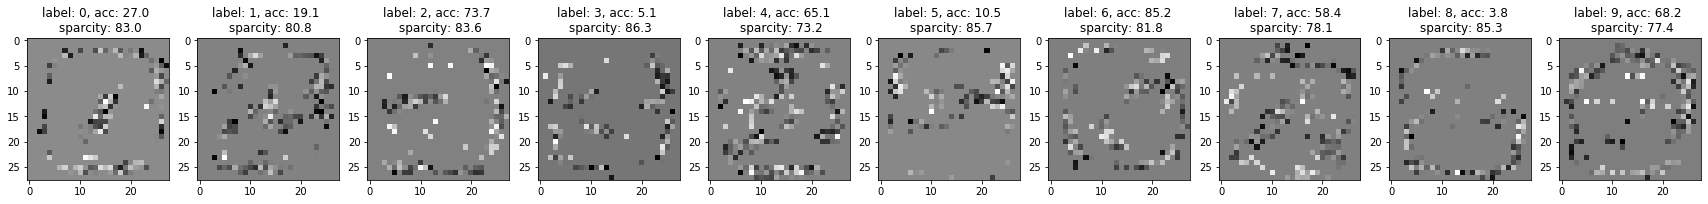

In [46]:
compile_model(model_pruned_layers_not_trained_best)
plot_weights(model_pruned_layers_not_trained_best)